# ETL and Quick Analysis

In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import bar_chart_race as bcr
import math
from os.path import join
import warnings
warnings.filterwarnings('ignore')

style = 'fivethirtyeight'

import re
from urllib import request
import requests
from bs4 import BeautifulSoup

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sns.set_style('darkgrid')
sns.set_palette(palette="ch:start=.2,rot=-.3")
%matplotlib inline


Int_Path = 'IntermediateData'
Dash_Path = r'DASH\assets'

start = time.time()

#### Functions for regular use + additional info

In [2]:
# Function 1: recursive function for finding a character (or, generally, a substring) in its nth occurrence in a string
def character_n(character, string, n):
    if n == 1:
        return string.find(character)
    else:
        return string.find(character, character_n(character, string, n-1) + 1)

# Function 2: check if a string has any digit
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)


dict_team_name = {'Academica': 'Académica',
                  'Académica OAF': 'Académica',
                  'FC Alverca': 'Alverca',
                  'FC Arouca': 'Arouca',
                  'Beira Mar': 'Beira-Mar',
                  'Os Belenenses': 'Belenenses',
                  'Belenenses SAD': 'Belenenses',
                  'B SAD': 'Belenenses',
                  'Boavista FC': 'Boavista',
                  'Campomaior': 'Campomaiorense',
                  'Aves': 'Desp. Aves',
                  'CD Aves': 'Desp. Aves',
                  'Chaves': 'Desp. Chaves',
                  'GD Chaves': 'Desp. Chaves',
                  'Estoril Praia': 'Estoril',
                  'Est Amadora': 'E. Amadora',
                  'Est. Amadora': 'E. Amadora',
                  'Famalicao': 'Famalicão',
                  'FC Famalicão': 'Famalicão',
                  'Porto': 'FC Porto',
                  'FC Felgueiras': 'Felgueiras',
                  'Gil Vicente FC': 'Gil Vicente',
                  'Leca': 'Leça',
                  'Leça FC': 'Leça',
                  'Leixoes': 'Leixões',
                  'Clube Sport Marítimo': 'Marítimo',
                  'Maritimo': 'Marítimo',
                  'Moreirense FC': 'Moreirense',
                  'Naval 1º Maio': 'Naval',
                  'FC Paços de Ferreira': 'Paços Ferreira',
                  'Pacos Ferreira': 'Paços Ferreira',
                  'Paços de Ferreira': 'Paços Ferreira',
                  'FC Penafiel': 'Penafiel',
                  'Portimonense SC': 'Portimonense',
                  'Rio Ave FC': 'Rio Ave',
                  'SC Salgueiros': 'Salgueiros',
                  'Sp Braga': 'SC Braga',
                  'Sp. Braga': 'SC Braga',
                  'Benfica': 'SL Benfica',
                  'Sp Lisbon': 'Sporting CP',
                  'Sporting': 'Sporting CP',
                  'Espinho': 'Sp. Espinho',
                  'SC Espinho': 'Sp. Espinho',
                  'CD Tondela': 'Tondela',
                  'Leiria': 'U. Leiria',
                  'UD Leiria': 'U. Leiria',
                  'Madeira': 'U. Madeira',
                  'Uniao Madeira': 'U. Madeira',
                  'União Madeira': 'U. Madeira',
                  'Vitória Guimarães': 'V. Guimarães',
                  'Guimaraes': 'V. Guimarães',
                  'Setubal': 'V. Setúbal',
                  'Vitória de Setúbal': 'V. Setúbal'
}

# I. DATA GATHERING AND PREPROCESSING ---------------------------------------------

## 1. Joining together all Liga NOS files in a single dataset, by scrapping **football-data.co.uk**

In [3]:
root_path = 'http://www.football-data.co.uk/'
portugal_path = root_path + 'portugalm.php'

# Parsing the url html to a python object 'html'
with request.urlopen(portugal_path) as data_source:
    html = data_source.read().decode('utf-8')

# Filtering the html for the chunks we need
Season_Identifier = 'Season'
Season_Position_html = [chunk.start() for chunk in re.finditer(Season_Identifier, html)]
csv_Identifier = 'P1.csv'
csv_Position_html = [chunk.start() for chunk in re.finditer(csv_Identifier, html)]

# Extracting the url for every season's csv file
Season_csv_chunk = []
for i in range(len(Season_Position_html)):
    Season_csv_chunk.append(html[Season_Position_html[i] : csv_Position_html[i] + len(csv_Identifier)])

# Joining the root_path with every url
file_identifier = 'mmz4281/yyyy/P1.csv'
csv_url = [root_path + season_file[-len(file_identifier):] for season_file in Season_csv_chunk]

# Creating a dataframe for storing the files
LigaNOS_files = pd.DataFrame({'File_url': csv_url})
LigaNOS_files['Season'] = LigaNOS_files['File_url'].map(lambda x: x[character_n('/', x, 4) + 1 : character_n('/', x, 5)]).astype('str')
LigaNOS_files['SeasonOrder'] = LigaNOS_files.index.map(lambda x: len(LigaNOS_files) - x)

# Appending together all files in a single dataset
df_liganos = pd.DataFrame()

for i in range(len(LigaNOS_files)):
    
    # files from seasons 0203, 0404 and 0607 are corrupted
    if i not in [13, 17, 18]:
        df = pd.read_csv(LigaNOS_files['File_url'][i]) \
               .dropna(axis=1, how='all')
        
        #Some preprocessing
        df = df[(df['HomeTeam'].notna())] # because some Seasons have noise rows, with just one or two columns filled with "random" values
        
        df['HomeTeam'] = df['HomeTeam'].str.strip()
        df['AwayTeam'] = df['AwayTeam'].str.strip()
        
        df.rename(columns = {'FTHG': 'HG',
                             'FTAG': 'AG',
                             'FTR': 'Res',
                             'PSH': 'PH',
                             'PSD': 'PD',
                             'PSA': 'PA'}, inplace = True) # Columns with two possible names - picking one of them
        df.insert(0, 'Season', LigaNOS_files['Season'][i])
        df['SeasonOrder'] = LigaNOS_files['SeasonOrder'][i]

        df['Date'] = pd.to_datetime(df['Date'])
        
        df_liganos = df_liganos.append(df, ignore_index = True)
        
df_liganos['HomeTeam'] = df_liganos['HomeTeam'].replace(dict_team_name)
df_liganos['AwayTeam'] = df_liganos['AwayTeam'].replace(dict_team_name)
        
# Variables
col_Results = ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'HG', 'AG', 'Res', 'HTHG', 'HTAG', 'HTR']
col_Match_Statistics = ['Attendance', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC',
                        'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP']
col_1X2_betting_odds = ['B365H', 'B365D', 'B365A', 'BSH', 'BSD', 'BSA', 'BWH', 'BWD', 'BWA', 'GBH', 'GBD', 'GBA', 'IWH', 'IWD',
                        'IWA', 'LBH', 'LBD', 'LBA', 'PH', 'PD', 'PA', 'SOH', 'SOD', 'SOA', 'SBH', 'SBD', 'SBA',
                        'SJH', 'SJD', 'SJA', 'SYH', 'SYD', 'SYA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA', 'Bb1X2', 'BbMxH',
                        'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA']
col_total_goals_betting_odds = ['BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 'GB>2.5', 'GB<2.5',
                                'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5']
col_Asian_handicap_betting_odds = ['BbAH', 'BbAHh', 'AHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'GBAHH', 'GBAHA', 'GBAH', 'LBAHH',
                                   'LBAHA', 'LBAH', 'B365AHH', 'B365AHA', 'B365AH', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA']
col_last_odds_before_match_starts = ['B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA',
                                     'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA',
                                     'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh',
                                     'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA']
LigaNOS_columns = col_Results \
                  + col_Match_Statistics \
                  + col_1X2_betting_odds \
                  + col_total_goals_betting_odds \
                  + col_Asian_handicap_betting_odds \
                  + col_last_odds_before_match_starts

# Checking which columns are not available in any season
not_available_columns = [column for column in LigaNOS_columns if column not in list(df_liganos.columns)]

df_liganos.to_csv(Dash_Path + r'\df_liganos.csv')
df_liganos

,Season,Div,Date,Time,HomeTeam,AwayTeam,HG,AG,Res,HTHG,...,SBA,GB>2.5,GB<2.5,GBAHH,GBAHA,GBAH,B365AH,SYH,SYD,SYA
0,2021,P1,2020-09-18,19:00,Famalicão,SL Benfica,1.0,5.0,A,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,P1,2020-09-18,21:15,V. Guimarães,Belenenses,0.0,1.0,A,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,P1,2020-09-19,16:00,Nacional,Boavista,3.0,3.0,D,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021,P1,2020-09-19,21:00,FC Porto,SC Braga,3.0,1.0,H,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021,P1,2020-09-20,16:00,Santa Clara,Marítimo,2.0,0.0,H,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6854,9495,P1,1995-05-28,NaN,U. Leiria,Beira-Mar,3.0,1.0,H,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6855,9495,P1,1995-05-28,NaN,Marítimo,Belenenses,3.0,0.0,H,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6856,9495,P1,1995-05-28,NaN,FC Porto,Tirsense,4.0,0.0,H,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6857,9495,P1,1995-05-28,NaN,V. Setúbal,U. Madeira,4.0,1.0,H,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1. Visualizing available columns for each season since 1994/95

<AxesSubplot:xlabel='Season'>

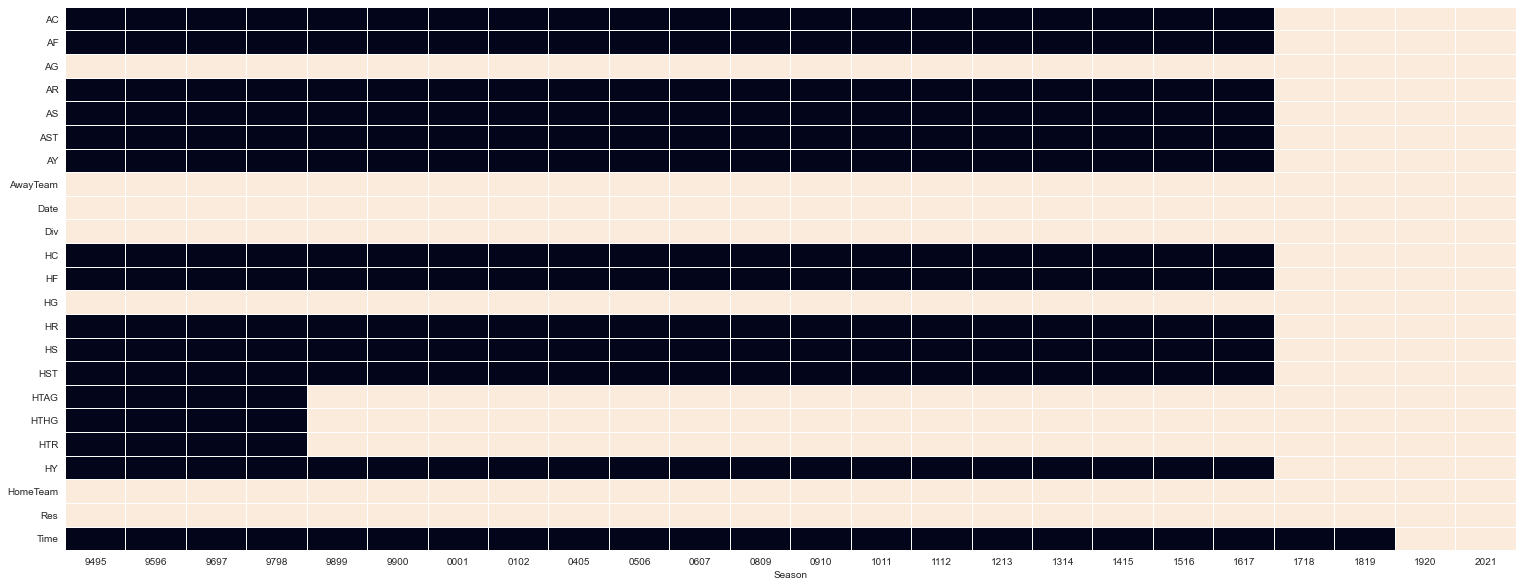

In [4]:
# Checking which columns are available for each season
visual_options = ['Restricted', 'Extended']
visual_choice = visual_options[0]  # By default, we only want to check results and match statistics. Feel free to input visual_options[1] for all columns 

if visual_choice == 'Extended':
    columns_to_check = df_liganos.columns
    figsize = (19, 33)
else:
    columns_to_check = np.setdiff1d(['Season', 'SeasonOrder'] + col_Results + col_Match_Statistics, not_available_columns)
    figsize = (26, 10)

df_columns_test = df_liganos.copy()[columns_to_check]

df_columns_test = df_columns_test.groupby(['SeasonOrder', 'Season']) \
                                 .count() \
                                 .sort_index() \
                                 .reset_index() \
                                 .drop(columns = ['SeasonOrder']) \
                                 .set_index('Season') \
                                 .T

len_df_columns_test = len(df_columns_test)

df_columns_test = df_columns_test.applymap(lambda x: 1 if x > 0 else 0)

plt.figure(figsize = figsize)

sns.heatmap(df_columns_test, linewidths = 0.01, linecolor = 'white', cbar = False)

## 2. Scrapping **futebol365.pt**, for finding out the round of each game

Further ahead, we're interested in apprasing how things went along the seasons, and the most common way of doing it is along rounds. We could simplify and assume that every n / 2 games (where n is the number of teams on a given season) constitute a round. However, some games are postponed or anticipated due to weather conditions, calendar adjustments to fit european games, and so on. Therefore, in some seasons we would see a team play more than one time in a round, and others not playing in a given round.

To overcome this handicap, we went on to scrap futebol365.pt for the round of each game, for all seasons since 1994/1995, using the Beautiful Soup package:

In [5]:
JornadaRes = []
EquipasRes1 = []
EquipasRes2 = []
Temporada = []

for season in range(1994,2021):

    season_years = str(season)[-2:] + str(season + 1)[-2:]

    # Each season has 2(n - 1) games, where n is the number of teams for that season
    rounds = (len(df_liganos[df_liganos['Season'] == season_years]['HomeTeam'].unique()) - 1) * 2 

    for round in range(1, rounds + 1):
        if int(season_years) == 1314:
            URL = 'https://www.futebol365.pt/competicao/392/?edition=' \
                  + str(season) \
                  + '&group=all&competition_phase=Campeonato&phase_round=' \
                  + str(round)
        else:
            URL = 'https://www.futebol365.pt/competicao/392/?edition=' \
                  + str(season) \
                  + '&competition_round=' \
                  + str(round) \
                  + '&group=all'

        page = requests.get(URL)
        soup = BeautifulSoup(page.content, 'html.parser')

        #JORNADAS
        results = soup.find(class_ = 'ink-grid all-container')
        job_elems = results.find_all('section', class_ = 'left-column-group')

        for job_elem in job_elems:
            result = job_elem.find('h5', class_ = 'headerTitleSimpleBackground')

            Equipas = soup.find(class_='left-column-group')
            job_equipas = Equipas.find_all('table', class_='ink-table ink-table-f365 alternating all-100')
            for job_equipa in job_equipas:
                result_equipa = job_equipa.find_all('td', class_='align-left hide-xlarge hide-large hide-medium')
                for res_equipa in result_equipa:
                    if (hasNumbers(res_equipa.text[0]) == False):

                        EquipasRes1.append(res_equipa.text.split('\n')[1])
                        EquipasRes2.append(res_equipa.text.split('\n')[3])
                        Temporada.append(str(season)+'-'+str(season+1))
                        JornadaRes.append(result.text.split("ª")[0])
                        
df_rounds = pd.DataFrame(list(zip(Temporada,JornadaRes, EquipasRes1, EquipasRes2)),
                         columns =['Season', 'Round', 'HomeTeam', 'AwayTeam'])

df_rounds.to_csv(Int_Path + r'\df_rounds.csv')

Since the code above takes a lot of time (and possibly the IP may be blocked due to several requests in a row), we suggest keeping the above cell commented and running the cell below with local files.

In [6]:
# calling the csv files stored locally
df_rounds = pd.read_csv(join(Int_Path, 'df_rounds.csv'), index_col = 0)

# df_rounds preprocessing
df_rounds['HomeTeam'] = df_rounds['HomeTeam'].replace(dict_team_name)
df_rounds['AwayTeam'] = df_rounds['AwayTeam'].replace(dict_team_name)

df_rounds['Round'] = df_rounds['Round'].map(lambda x: int(x[-2:]))

df_rounds = df_rounds.drop_duplicates().reset_index(drop = True)
df_rounds['Season'] = df_rounds['Season'].apply(lambda x: ''.join([year[-2:] for year in x.split('-')]))

df_rounds.to_csv(Dash_Path + r'\df_rounds.csv')
df_rounds

,Season,Round,HomeTeam,AwayTeam
0,9495,1,Farense,Sporting CP
1,9495,1,Gil Vicente,Tirsense
2,9495,1,Desp. Chaves,Salgueiros
3,9495,1,FC Porto,SC Braga
4,9495,1,Marítimo,V. Setúbal
...,...,...,...,...
6877,2021,34,Santa Clara,Farense
6878,2021,34,Sporting CP,Marítimo
6879,2021,34,Tondela,Paços Ferreira
6880,2021,34,V. Guimarães,SL Benfica


## 3. Scrapping **zerozero.pt/** for:
* ### teamwise yellow and red cards
* ### top scorers
* ### top assistants
* ### playerwise yellow and red cards

Furthermore, yellow and red card information is available only for seasons 2017/18 and after, thus we scrapped zerozero.pt for this info, which additionally included the number of double yellow cards. Therefore, we decided to get data even for seasons after and including 2017/18.

Additionally, we are interested in player stats for our dashboard to come. Top scorers and top assistants are almost mandatory to present, and it would be nice to have yellow and red cards shown to every player and their rank. We scrapped this data from zerozero.pt as well.

In [7]:
start = time.time()

edicao_dict = {'2021': '147383',
               '1920': '135717',
               '1819': '125220',
               '1718': '109369',
               '1617': '98399',
               '1516': '87508',
               '1415': '70079',
               '1314': '58581',
               '1213': '47487',
               '1112': '22951',
               '1011': '15339',
               '0910': '8838',
               '0809': '2306',
               '0708': '1582',
               '0607': '1295',
               '0506': '1138',
               '0405': '495',
               '0304': '5',
               '0203': '1',
               '0102': '119',
               '0001': '116',
               '9900': '114',
               '9899': '112',
               '9798': '110',
               '9697': '108',
               '9596': '106',
               '9495': '121'}

df_cards = pd.DataFrame()
df_scorers = pd.DataFrame()
df_assists = pd.DataFrame()
df_player_cards = pd.DataFrame()

seconds = 15

for season in range(2012, 2021):

    season_years = str(season)[-2:] + str(season + 1)[-2:]
    season_address = edicao_dict[season_years]
    
    print(season_years)
    
    table_MN = pd.read_html('https://www.zerozero.pt/edition_stats.php?v=et4&o=a&sc=0&v1=e&v2=t&v3=4&pais=0&pos=0&id_equipa=0&id_edicao=' + str(season_address), match='Equipa')
    df_cards_season = table_MN[0]
    time.sleep(seconds)

    table_scorers = pd.read_html('https://www.zerozero.pt/edition_stats.php?v=jt1&o=g&sc=0&v1=j&v2=t&v3=1&pais=0&pos=0&id_equipa=0&id_edicao=' + str(season_address), match='Equipa')
    df_scorers_season = table_scorers[0]
    time.sleep(seconds)
    
    table_assists = pd.read_html('https://www.zerozero.pt/edition_stats.php?v=jt14&o=ass&sc=0&v1=j&v2=t&v3=14&pais=0&pos=0&id_equipa=0&id_edicao=' + str(season_address), match='Equipa')
    df_assists_season = table_assists[0]
    time.sleep(seconds)

    table_player_cards = pd.read_html('https://www.zerozero.pt/edition_stats.php?v=jt4&o=a&sc=0&v1=j&v2=t&v3=4&pais=0&pos=0&id_equipa=0&id_edicao=' + str(season_address), match='Equipa')
    df_player_cards_season = table_player_cards[0]
    time.sleep(seconds)
    
    
    for df in [df_cards_season, df_scorers_season, df_assists_season, df_player_cards_season]:

        df.drop(['Unnamed: 0'], axis = 1, inplace=True)
        df.dropna(inplace = True)
        df.insert(0, 'Season', season_years)
        df.insert(1, 'SeasonOrder', df_liganos[df_liganos['Season'] == str(season_years)]['SeasonOrder'].values[0])
            
    df_cards = df_cards.append(df_cards_season)
    df_scorers = df_scorers.append(df_scorers_season)
    df_assists = df_assists.append(df_assists_season)
    df_player_cards = df_player_cards.append(df_player_cards_season)

    df_cards.to_csv(join(Int_Path, 'df_cards.csv'))
    df_scorers.to_csv(join(Int_Path, 'df_scorers.csv'))
    df_assists.to_csv(join(Int_Path, 'df_assists.csv'))
    df_player_cards.to_csv(join(Int_Path, 'df_player_cards.csv'))

Since the code above takes a lot of time (and possibly the IP may be blocked due to several requests in a row), we suggest keeping the above cell commented and running the cell below with local files.

In [8]:
df_cards = pd.read_csv(Int_Path + r'\df_cards.csv', index_col = 0)

# df_cards preprocessing
df_cards['Equipa'] = df_cards['Equipa'].replace(dict_team_name)

df_cards = df_cards.rename(columns = {'Equipa': 'Team'}) \
                   .drop(columns = ['J'])

df_cards['Season'] = df_cards['Season'].map(lambda x: '0' * (4 - len(str(x))) + str(x))
df_cards['Season'] = df_cards['Season'].astype(str)
for column in df_cards.columns[1:]:
    try:
        df_cards[column] = df_cards[column].astype(int)
    except:
        pass

df_cards = df_cards.drop_duplicates().reset_index(drop = True)

df_cards.to_csv(Dash_Path + r'\df_cards.csv')
df_cards

,Season,Team,A,2A,VE
0,9495,U. Madeira,108,6,5
1,9495,U. Leiria,100,4,5
2,9495,SL Benfica,96,5,4
3,9495,Beira-Mar,95,7,3
4,9495,Boavista,93,6,3
...,...,...,...,...,...
465,2021,Rio Ave,61,2,3
466,2021,Gil Vicente,60,2,2
467,2021,Paços Ferreira,58,0,2
468,2021,SC Braga,55,1,4


In [9]:
df_scorers = pd.read_csv(Int_Path + r'\df_scorers.csv', index_col = 0)
df_assists = pd.read_csv(Int_Path + r'\df_assists.csv', index_col = 0)
df_player_cards = pd.read_csv(Int_Path + r'\df_player_cards.csv', index_col = 0)


# df_scorers, df_assists and df_player_cards preprocessing
count = 0
for df in [df_scorers, df_assists, df_player_cards]:
    df = df.rename(columns = {'Jogador': 'Player'}) \
                           .drop_duplicates() \
                           .reset_index(drop = True)
    df.insert(2, 'Team', df['Player'].map(lambda x: x.split('[')[1][:-1].strip()) \
                                                     .replace(dict_team_name))

    df['Player'] = df['Player'].map(lambda x: x[:x.find('[')].strip())

    df['Season'] = df['Season'].map(lambda x: '0' * (4 - len(str(x))) + str(x)) #Isto é para ser colocado diretamente no código de scrapping quando o corrermos antes de enviar o trabalho
    df['Season'] = df['Season'].astype(str)
    for column in df.columns[1:]:
        try:
            df[column] = df[column].astype(int)
        except:
            pass

    df = df.merge(df_liganos[['Season', 'SeasonOrder']].drop_duplicates(), on = 'Season', how = 'left') #Isto é para sair depois de vltar a correr o scrapping e colocar lá esta instrução
    
    if count == 0:
        df_scorers = df.copy()
    elif count == 1:
        df_assists = df.copy()
    elif count == 2:
        df_player_cards = df.copy()
        
    count += 1
    
df_scorers.to_csv(Dash_Path + r'\df_scorers.csv')
df_assists.to_csv(Dash_Path + r'\df_assists.csv')
df_player_cards.to_csv(Dash_Path + r'\df_player_cards.csv')

print(" \n\n ----------------------------- df_scores sample ------------------------------------ \n")
print(df_scorers.head(2))
print(" \n\n ---------------------------- df_assists sample ------------------------------------ \n")
print(df_assists.head(2))
print(" \n\n --------------------------- df_player_cards sample -------------------------------- \n")
print(df_player_cards.head(2))
print("\n")

 

 ----------------------------- df_scores sample ------------------------------------ 

  Season              Player      Team   J   G  PEN  AG  MPG  GTIT  GSUP  \
0   9495        Hassan Nader   Farense  31  21    3   0  131    21     0   
1   9495  Domingos Paciência  FC Porto  32  19    2   0  114    17     2   

   GPTS  GVIT  GRVV  PGE  SeasonOrder  
0     1     5     0   48          1.0  
1     0     2     0   26          1.0  
 

 ---------------------------- df_assists sample ------------------------------------ 

  Season      Player         Team   J  G  ASS  INF  PINF  SeasonOrder
0   0405    Jorginho   V. Setúbal  32  9    9   18    39         11.0
1   0405  Hugo Viana  Sporting CP  32  6    8   14    21         11.0
 

 --------------------------- df_player_cards sample -------------------------------- 

  Season Player         Team   J   A  2A  VE  SeasonOrder
0   1112    Ney   V. Setúbal  23  12   1   0         18.0
1   1112  Elias  Sporting CP  25  12   1   0         18

## 4. Retrieving game related variables

In [10]:
edicao_dict2021 = {  'G/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=golos&id_edicao=147383',
                     'GS/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=goloss&id_edicao=147383',
                     'A/J': 'https://www.zerozero.pt/team_time_stats.php?tpstat=y&id=147383',
                     'V/J': 'https://www.zerozero.pt/team_time_stats.php?tpstat=r&id=147383',
                     'MediaPasses': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=54&id_edicao=147383',
                     'MediaPassesCertos': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=53&id_edicao=147383',
                     'MediaPosseBola': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=48&id_edicao=147383',
                     'PontBaliza/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=59&id_edicao=147383',
                     'Lanca/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=62&id_edicao=147383',
                     'RematDef/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=63&id_edicao=147383', 
                     'Remates/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=18&id_edicao=147383', 
                     'Cantos/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=20&id_edicao=147383',
                     'TackleWon/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=60&id_edicao=147383',
                     'Alivios/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=61&id_edicao=147383',
                     'RematesFora/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=58&id_edicao=147383',
                     'Defesa/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=56&id_edicao=147383', 
                     'RemateBaliza/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=47&id_edicao=147383',
                     'ForaJogo/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=21&id_edicao=147383'}

edicao_dict1920 = {  'G/J': 'https://www.zerozero.pt/team_time_stats.php?id=135717',
                     'GS/J': 'https://www.zerozero.pt/team_time_stats.php?tpstat=ga&id=135717',
                     'A/J': 'https://www.zerozero.pt/team_time_stats.php?tpstat=y&id=135717',
                     'V/J': 'https://www.zerozero.pt/team_time_stats.php?tpstat=r&id=135717',
                     'MediaPasses': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=54&id_edicao=135717',
                     'MediaPassesCertos': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=53&id_edicao=135717',
                     'MediaPosseBola': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=48&id_edicao=135717',
                     'PontBaliza/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=59&id_edicao=135717',
                     'Lanca/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=62&id_edicao=135717',
                     'RematDef/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=63&id_edicao=135717', 
                     'Remates/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=18&id_edicao=135717', 
                     'Cantos/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=20&id_edicao=135717',
                     'TackleWon/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=60&id_edicao=135717',
                     'Alivios/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=61&id_edicao=135717',
                     'RematesFora/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=58&id_edicao=135717',
                     'Defesa/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=56&id_edicao=135717', 
                     'RemateBaliza/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=47&id_edicao=135717',
                     'ForaJogo/J': 'https://www.zerozero.pt/team_stats_compare.php?tpstat=21&id_edicao=135717'}

df1920 = pd.DataFrame() 
df2021 = pd.DataFrame()

seconds = 15
counter = 0

df_class = pd.read_csv(join(Dash_Path, 'df_class.csv'))
df_class1920 = df_class[df_class['Season'] == 1920]
df_class1920 = df_class1920[['Unnamed: 0', 'Team', 'Points']]
df_class2021 = df_class[df_class['Season'] == 2021]
df_class2021 = df_class2021[['Unnamed: 0', 'Team', 'Points']]
df1920 = df_class1920.set_index("Unnamed: 0")
df2021 = df_class2021.set_index("Unnamed: 0")

df1920['Team'] = df1920['Team'].replace(dict_team_name)
df2021['Team'] = df2021['Team'].replace(dict_team_name)

for key in edicao_dict1920:

    counter += 1
    print(edicao_dict1920[key])
    if (counter <= 4):
        table_MN = pd.read_html(edicao_dict1920[key], match = 'Jogos')
        df_temp = table_MN[0]
        time.sleep(seconds)
    else:
        table_MN = pd.read_html(edicao_dict1920[key], match = 'Media')
        df_temp = table_MN[0]
        time.sleep(seconds)
    
    df_temp['Unnamed: 0'] = df_temp['Unnamed: 0'].replace(dict_team_name)
    df1920[str(key)] = df1920['Team'].map(str(df_temp.set_index('Unnamed: 0')[str(key)]))
                                          
VJ_means = df['V/J'].mean()
df1920['V/J'].fillna(VJ_means, inplace=True)
df1920['V/J'] = round(df['V/J'], 1)
df1920.to_csv("df1920.csv")
                                          
for key in edicao_dict2021:

    counter += 1
    print(edicao_dict2021[key])
    if (counter <= 4):
        table_MN = pd.read_html(edicao_dict2021[key], match = 'Jogos')
        df_temp = table_MN[0]
        time.sleep(seconds)
    else:
        table_MN = pd.read_html(edicao_dict2021[key], match = 'Media')
        df_temp = table_MN[0]
        time.sleep(seconds)
    
    df_temp['Unnamed: 0'] = df_temp['Unnamed: 0'].replace(dict_team_name)
    df2021[str(key)] = df2021['Team'].map(str(df_temp.set_index('Unnamed: 0')[str(key)]))
                                          
VJ_means = df['V/J'].mean()
df2021['V/J'].fillna(VJ_means, inplace=True)
df2021['V/J'] = round(df['V/J'], 1)
df2021.to_csv("df2021.csv")

In [11]:
df1920 = pd.read_csv(Int_Path + r"\df1920.csv")
df2021 = pd.read_csv(Int_Path + r"\df2021.csv")

df2021.head()

,Unnamed: 0,Team,Points,G/J,GS/J,A/J,V/J,MediaPasses,MediaPassesCertos,MediaPosseBola,...,Lanca/J,RematDef/J,Remates/J,Cantos/J,TackleWon/J,Alivios/J,RematesFora/J,Defesa/J,RemateBaliza/J,ForaJogo/J
0,0,Sporting CP,73,1.8,0.5,2.5,0.1,474.6,384.9,58.1,...,24.6,3.1,13.9,3.1,9.0,12.9,6.1,1.7,4.7,1.4
1,1,FC Porto,67,2.0,0.9,1.7,0.1,498.0,410.5,60.6,...,25.6,3.3,14.3,3.3,8.8,12.5,5.5,1.8,5.6,2.1
2,2,SL Benfica,63,1.9,0.7,2.2,0.1,578.0,490.4,63.8,...,26.1,3.1,14.1,3.1,9.0,11.4,6.1,2.5,5.0,2.4
3,3,SC Braga,58,1.6,1.0,1.9,0.2,505.9,413.6,56.4,...,23.1,2.7,14.4,2.7,9.1,13.7,6.8,2.1,5.0,2.3
4,4,Paços de Ferreira,45,1.2,1.2,2.0,0.1,373.4,287.8,45.9,...,20.7,2.3,10.5,2.3,10.8,17.8,4.5,2.3,3.7,2.1


## 5. Computing Liga NOS classifications table from the results dataset, for a single season

A classification table provides, for each team:
* Number of games played (**Games**)
* Number of wins (**Won**)
* Number of draws (**Drawn**)
* Number of defeats (**Lost**)
* Number of points (**Points**)
* Number of goals scored (**GoalsScored**)
* Number of goals conceded (**GoalsConceded**)
* Difference between goals scored and goals conceded (**GoalsDifference**)

### 5.1. Converting the dataset into team wise

In [12]:
Season = "1920"

# PREPROCESSING
def table_preprocessing(Season):

    df = df_liganos[df_liganos['Season'] == Season]
    df = df[df.columns & (['Season'] + col_Results + ['B365H', 'B365D', 'B365A'])]
    df = df.rename({'HG': 'H_Goals',
                    'AG': 'A_Goals'}, axis = 1)

    df = df[['Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'Res', 'H_Goals', 'A_Goals', 'B365H', 'B365D', 'B365A']]

    # Awarding points from the goal difference
    point_conditions = [(df['H_Goals'] < df['A_Goals']),
                        (df['H_Goals'] == df['A_Goals']),
                        (df['H_Goals'] > df['A_Goals'])]
    H_points = [0, 1, 3]
    A_points = [3, 1, 0]

    df['H_Points'] = np.select(point_conditions, H_points)
    df['A_Points'] = np.select(point_conditions, A_points)
    
    # Fetching each game's round
    df['Season'] = df['Season'].astype('str')
    df = df.merge(df_rounds, on = ['Season', 'HomeTeam', 'AwayTeam'], how = 'left')
    
    for column in df.columns[1:].drop(['B365H', 'B365D', 'B365A']):
        try:
            df[column] = df[column].astype(int)
        except:
            pass
    
    return df

df_preprocessed = table_preprocessing(Season)
    
# CONVERTING THE TABLE INTO TEAM WISE
def table_teamwise(df_preprocessed):
    
    df = df_preprocessed.copy()

    df.insert(0, 'GameID', [i for i in range(len(df))])

    df = df.append(df, ignore_index = True)
    df = df.sort_values(by = ['Round', 'GameID']).reset_index(drop = True)

    df['Team'] = df['HomeTeam']
    df['OpponentTeam'] = df['AwayTeam']
    df['GoalsScored'] = df['H_Goals']
    df['GoalsConceded'] = df['A_Goals']
    df['Points'] = df['H_Points']
    df['Premises'] = 'Home'

    for i in range(1, len(df), 2):
        df['Team'][i] = df['AwayTeam'][i]
        df['OpponentTeam'][i] = df['HomeTeam'][i]
        df['GoalsScored'][i] = df['A_Goals'][i]
        df['GoalsConceded'][i] = df['H_Goals'][i]
        df['Points'][i] = df['A_Points'][i]
        df['Premises'][i] = 'Away'

    # Results from the goal difference
    result_conditions = [(df['GoalsScored'] < df['GoalsConceded']),
                         (df['GoalsScored'] == df['GoalsConceded']),
                         (df['GoalsScored'] > df['GoalsConceded'])]
    result = ['Lost', 'Drawn', 'Won']
    df['Result'] = np.select(result_conditions, result)

    df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

    df = df[['Season', 'GameID', 'Round', 'Date', 'Team', 'OpponentTeam', 'Result', 'Premises', 'GoalsScored', 'GoalsConceded', 'Points']]
    
    return df

df_teamwise = table_teamwise(table_preprocessing(Season))
df_teamwise

,Season,GameID,Round,Date,Team,OpponentTeam,Result,Premises,GoalsScored,GoalsConceded,Points
0,1920,0,1,2019-09-08,Portimonense,Belenenses,Drawn,Home,0,0,1
1,1920,0,1,2019-09-08,Belenenses,Portimonense,Drawn,Away,0,0,1
2,1920,1,1,2019-10-08,Santa Clara,Famalicão,Lost,Home,0,2,0
3,1920,1,1,2019-10-08,Famalicão,Santa Clara,Won,Away,2,0,3
4,1920,2,1,2019-10-08,Gil Vicente,FC Porto,Won,Home,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...
607,1920,303,34,2020-07-26,Tondela,Moreirense,Won,Away,2,1,3
608,1920,304,34,2020-07-26,Portimonense,Desp. Aves,Won,Home,2,0,3
609,1920,304,34,2020-07-26,Desp. Aves,Portimonense,Lost,Away,0,2,0
610,1920,305,34,2020-07-26,V. Setúbal,Belenenses,Won,Home,2,0,3


### 5.2. Classification

In [13]:
## COMPUTING FINAL CLASSIFICATION
def compute_final_table(df_teamwise):
    
    df = pd.DataFrame()
    
    for column in ['Points', 'GoalsScored', 'GoalsConceded']:
        df[column] = df_teamwise.groupby('Team').sum()[column]

    df['Games'] = df_teamwise.groupby('Team').max()['Round']
    df['GoalsDifference'] = df['GoalsScored'] - df['GoalsConceded']
    
    df['Season'] = df_teamwise['Season'].unique()[0]


    Results = df_teamwise.groupby(['Team', 'Result']).size().unstack(fill_value=0)
    df = df.join(Results)


    # Tiebreaker Criteria: 1. Points, 2. Goals Difference, 3. GoalsScored
    df = df.sort_values(by = ['Points', 'GoalsDifference', 'GoalsScored'], ascending = False).reset_index()
    df['Classification'] = [i for i in range(1, len(df) + 1)]
    df.set_index('Classification', inplace = True)

    df = df[['Season', 'Team', 'Games', 'Won', 'Drawn', 'Lost', 'Points', 'GoalsScored', 'GoalsConceded', 'GoalsDifference']]
    df = df.merge(df_cards, on = ['Team', 'Season'], how = 'left')
    
    return df

final_table = compute_final_table(df_teamwise)
final_table

,Season,Team,Games,Won,Drawn,Lost,Points,GoalsScored,GoalsConceded,GoalsDifference,A,2A,VE
0,1920,FC Porto,34,26,4,4,82,74,22,52,87,2,1
1,1920,SL Benfica,34,24,5,5,77,71,26,45,71,1,1
2,1920,SC Braga,34,18,6,10,60,61,40,21,91,2,4
3,1920,Sporting CP,34,18,6,10,60,49,34,15,91,3,0
4,1920,Rio Ave,34,15,10,9,55,48,36,12,71,2,5
5,1920,Famalicão,34,14,12,8,54,53,51,2,99,3,8
6,1920,V. Guimarães,34,13,11,10,50,53,38,15,69,3,2
7,1920,Moreirense,34,10,13,11,43,42,44,-2,82,2,2
8,1920,Gil Vicente,34,11,10,13,43,40,44,-4,76,3,1
9,1920,Santa Clara,34,11,10,13,43,36,41,-5,75,1,2


# II. QUICK VISUALIZATION MODULE -----------------------------------------

## 1. Classification by Round

### 1.1. Using Heatmaps

<AxesSubplot:xlabel='Round', ylabel='Team'>

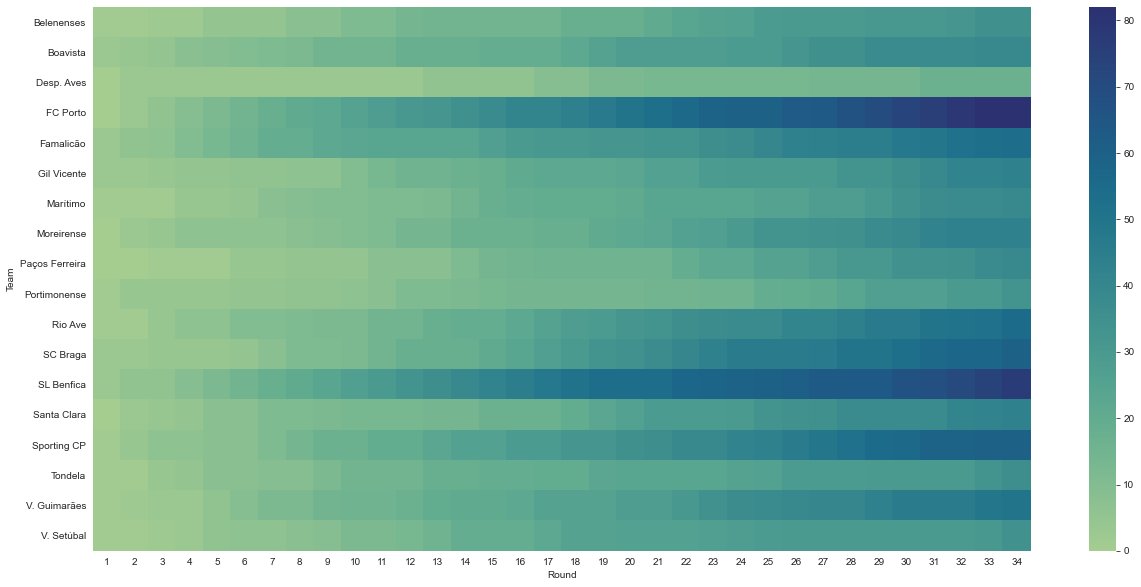

In [14]:
bcr_df = df_teamwise.copy()

# Cumulative points
bcr_df['TotalPoints'] = bcr_df.groupby('Team')['Points'].transform(pd.Series.cumsum).values

bcr_df = bcr_df[['Team', 'Round', 'TotalPoints']]
bcr_df = bcr_df.drop_duplicates()
bcr_df = bcr_df.reset_index().pivot_table(values='TotalPoints', index='Round', columns='Team', aggfunc='max')

bcr_df.to_csv(join(Dash_Path, 'bcr_df.csv'))

fig = plt.figure(figsize = (21, 10))

sns.heatmap(bcr_df.T, cmap = 'crest')

### 1.2. Using Bar Chart Races

In [15]:
bcr.bar_chart_race(
    df = bcr_df,
    filename = None,
    bar_size = .85,
    period_label = {'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    figsize = (7, 4),
    cmap = 'dark12',
    title = 'Liga NOS Classification, ' + Season + ' Season',
    shared_fontdict = {'family' : 'Segoe UI', 'color' : '.1'}
)  

## 2. Plotly Dash

### 2.1. Exporting tables for Dash App
Since we will be developing the app in another separate script, in order to avoid computing everything again, needed dataframes will be exported to disk to be again uploaded in the Dash app.

In [16]:
# Append all seasons classification
df_class = pd.DataFrame()
for season in df_liganos['Season'].unique():
    season_order = df_liganos[df_liganos['Season'] == season]['SeasonOrder'].values[0]
    
    df_class_int = compute_final_table(table_teamwise(table_preprocessing(season)))
    df_class_int['SeasonOrder'] = season_order
    
    df_class = df_class.append(df_class_int, ignore_index = True)

df_class.to_csv(join(Dash_Path, 'df_class.csv'))
df_class.head()

,Season,Team,Games,Won,Drawn,Lost,Points,GoalsScored,GoalsConceded,GoalsDifference,A,2A,VE,SeasonOrder
0,2021,Sporting CP,31,24,7,0,79,56,15,41,74,2,1,27
1,2021,FC Porto,32,22,8,2,74,67,29,38,51,3,1,27
2,2021,SL Benfica,31,20,7,4,67,59,22,37,64,0,0,27
3,2021,SC Braga,32,18,6,8,60,51,32,19,55,1,4,27
4,2021,Paços Ferreira,32,14,8,10,50,37,37,0,58,0,2,27


In [17]:
# Append all seasons round cumulative classification
df_bcr = pd.DataFrame()
for season in df_liganos['Season'].unique():
    season_order = df_liganos[df_liganos['Season'] == season]['SeasonOrder'].values[0]
    
    df_bcr_int = table_teamwise(table_preprocessing(season))

    # Cumulative points
    df_bcr_int['TotalPoints'] = df_bcr_int.groupby('Team')['Points'].transform(pd.Series.cumsum).values

    df_bcr_int = df_bcr_int[['Team', 'Round', 'TotalPoints']]
    df_bcr_int = df_bcr_int.drop_duplicates()
    
    df_bcr_int.insert(0, 'Season', season)
    df_bcr_int.insert(1, 'SeasonOrder', season_order)

    # Computing the ranks for each round and storing it in Position
    df_bcr_int2 = pd.DataFrame()
    for game_round in df_bcr_int['Round'].unique():
        
        df_bcr_int3 = df_bcr_int[df_bcr_int['Round'] == game_round].sort_values(by = 'TotalPoints', ascending = False)
        df_bcr_int3['Position'] = [i for i in range(1, len(df_bcr_int3) + 1)]
        df_bcr_int2 = df_bcr_int2.append(df_bcr_int3, ignore_index = True)
        
    df_bcr = df_bcr.append(df_bcr_int2, ignore_index = True)
    
df_bcr.to_csv(join(Dash_Path, 'df_bcr.csv'))
df_bcr.head()

,Season,SeasonOrder,Team,Round,TotalPoints,Position
0,2021,27,Sporting CP,1,3,1
1,2021,27,Belenenses,1,3,2
2,2021,27,FC Porto,1,3,3
3,2021,27,Santa Clara,1,3,4
4,2021,27,SL Benfica,1,3,5


In [18]:
# Append all seasons games with its score
df_games = pd.DataFrame()
for season in df_liganos['Season'].unique():
    season_order = df_liganos[df_liganos['Season'] == season]['SeasonOrder'].values[0]
    
    df_games_int = table_preprocessing(season)
    df_games_int['Match'] = df_games_int['HomeTeam'] + " " + df_games_int['H_Goals'].astype(str) + " - " + df_games_int['A_Goals'].astype(str) + " " + df_games_int['AwayTeam']
    
    df_games_int = df_games_int[['Round', 'Date', 'Match', 'B365H', 'B365D', 'B365A']]
    
    df_games_int.insert(0, 'Season', season)    
    df_games_int.insert(1, 'SeasonOrder', season_order)
    df_games = df_games.append(df_games_int, ignore_index = True)

df_games.to_csv(join(Dash_Path, 'df_games.csv'))
df_games.head()

,Season,SeasonOrder,Round,Date,Match,B365H,B365D,B365A
0,2021,27,1,2020-09-18,Famalicão 1 - 5 SL Benfica,7.50,5.00,1.36
1,2021,27,1,2020-09-18,V. Guimarães 0 - 1 Belenenses,1.45,4.33,7.00
2,2021,27,1,2020-09-19,Nacional 3 - 3 Boavista,2.55,3.10,2.87
3,2021,27,1,2020-09-19,FC Porto 3 - 1 SC Braga,1.61,4.00,5.00
4,2021,27,1,2020-09-20,Santa Clara 2 - 0 Marítimo,2.10,3.20,3.60
